In [223]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm
import matplotlib.pyplot as plt

# Autoencoder
The goal is to define and train a simple autoencoder model on the MNIST dataset. The model will have a simple architecture with linear layers in the encoder, and linear layers in the decoder. The encoder will reduce the input image to a lower-dimensional latent space, and the decoder will reconstruct the image from the latent space.

## Dataset
We use the MNIST dataset from torchvision.

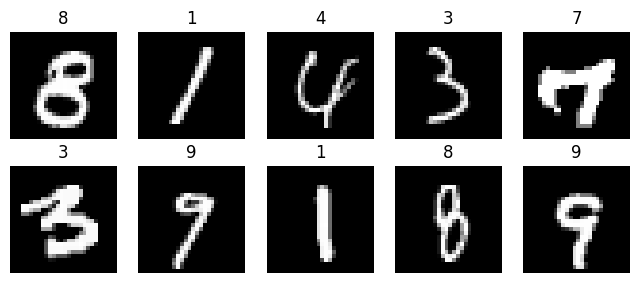

In [224]:
train_data = datasets.MNIST(
    root="../data", train=True, download=True, transform=ToTensor()
)
test_data = datasets.MNIST(
    root="../data", train=False, download=True, transform=ToTensor()
)

figure = plt.figure(figsize=(8, 3.2))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="binary_r")

In [225]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

## Autoencoder model
The autoencoder model consists of two parts: the encoder and the decoder. The encoder consists of convolutional layers, then linear layers to obtain the latent space vector, and the decoder consists of linear layers then transposed convolutional layers. The encoder reduces the input image to a lower-dimensional latent space, and the decoder reconstructs the image from the latent space.

In [226]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16 * 7 * 7, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (16, 7, 7)),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Training the model
We train the model using the mean squared error loss function.

In [227]:
latent_dim, lr, num_epochs = 8, 1e-3, 16
autoencoder = Autoencoder(latent_dim)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)

In [228]:
train_losses, test_losses = [], []

for epoch in  (pbar := tqdm(range(num_epochs), desc="Epochs")):
    epoch_train_loss, epoch_test_loss = [], []
    
    for images, _ in train_dataloader:
        outputs = autoencoder(images)
        loss = loss_fn(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
        pbar.set_postfix(Batch=f"{len(epoch_train_loss)/len(train_dataloader) * 100:.2f}%", Train_loss=f"{loss.item():.4f}", Test_loss=f"{([0] + test_losses)[-1]:.4f}")
    
    with torch.no_grad():
        for images, _ in test_dataloader:
            outputs = autoencoder(images)
            loss = loss_fn(outputs, images)
            epoch_test_loss.append(loss.item())
    
    train_losses.append(sum(epoch_train_loss) / len(epoch_train_loss))
    test_losses.append(sum(epoch_test_loss) / len(epoch_test_loss))

Epochs: 100%|██████████| 16/16 [10:55<00:00, 40.98s/it, Batch=100.00%, Test_loss=0.0198, Train_loss=0.0198]


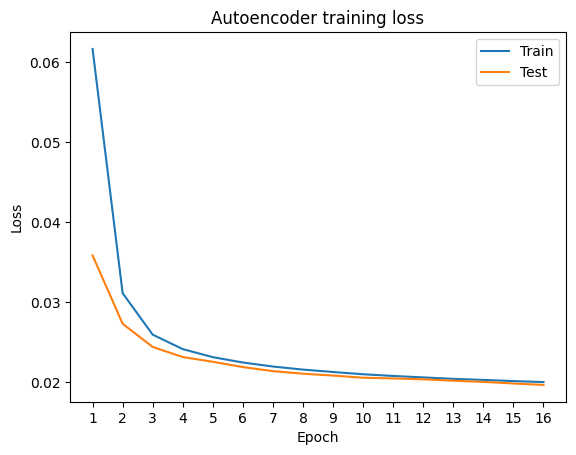

In [229]:
xrange = range(1, num_epochs + 1)
plt.plot(xrange, train_losses, label="Train")
plt.plot(xrange, test_losses, label="Test")
plt.xlabel("Epoch")
plt.xticks(xrange)
plt.ylabel("Loss")
plt.legend()
plt.title("Autoencoder training loss")
plt.show()

## Visualizing the results
We visualize the original and reconstructed images for a few random samples from the test dataset.

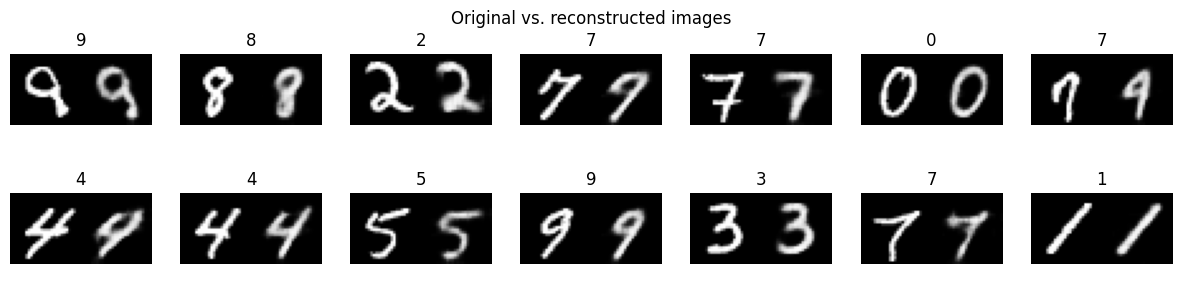

In [230]:
figure = plt.figure(figsize=(15, 3.3))
plt.title("Original vs. reconstructed images")
plt.axis("off")
cols, rows = 7, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]
    output = autoencoder(img.unsqueeze(0))
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(torch.cat([img.squeeze(), output.squeeze()], dim=1).detach().numpy(), cmap="binary_r")